# Home Assignment

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_feather('/Users/idodavid/Downloads/home_assignment.feather')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726288 entries, 0 to 726287
Columns: 881 entries, HKTLMYY to TLJYWBE
dtypes: float64(794), int64(43), object(44)
memory usage: 4.8+ GB


In [3]:
import cufflinks as cf; cf.go_offline()

## Data Integrity

### Duplicated rows

In [4]:
df.duplicated().sum()

0

### Data types

In [5]:
columns_type = df.dtypes

In [6]:
columns_type.value_counts()

float64    794
object      44
int64       43
dtype: int64

### Fixing value issues

In [7]:
df.replace(-np.inf, np.nan, inplace=True)
df.replace(np.inf, np.nan, inplace=True)
df.replace('nan',np.nan, inplace=True)
df.replace('-∞', float('-inf'), inplace=True)
df.replace('False', False, inplace=True)
df.replace('FALSE', False, inplace=True)
df.replace('True', True, inplace=True)
df.replace('TRUE', True, inplace=True)

In [8]:
cat_columns = df.dtypes[df.dtypes == 'object'].index
for c in cat_columns:
    if c in ['TQSLCKT',
             'FRPZZAO',
             'CJICMVV',
             'CNECOOI',
             'HLUJJDC',
             'OYBONYX',
             'DRELDXX',
             'IMAZODZ',
             'ABMWXIO',
             'EYAUITY',
             'TOTBAZC',
             'TERIJOV',
             'FKCIOEN']:
        continue
    df[c]=df[c].astype(float)

In [9]:
df.dtypes.value_counts()

float64    825
int64       43
object      13
dtype: int64

### Target analysis

In [10]:
target_test = 'TLJYWBE'
failure_thd = 1e-5
target_test_col = df[target_test]

In [11]:
target_test_col.isna().sum()

16770

In [12]:
df = df[target_test_col.notnull()]
df.shape

(709518, 881)

In [13]:
(target_test_col >= failure_thd).value_counts(dropna=False)

False    726224
True         64
Name: TLJYWBE, dtype: int64

## Handling duplicated columns

In [14]:
def nan_positions_match(df, col1, col2):
    return (df[col1].isnull() == df[col2].isnull()).all()

def categorical_distribution_match(df, col1, col2):
    # Get value counts for each column
    vc1 = df[col1].value_counts()
    vc2 = df[col2].value_counts()
    is_equal_distribution = vc1.values.tolist() == vc2.values.tolist()
    category_matching = list(zip(vc1.index, vc2.index))

    # Check if indices for each category match
    all_categories_match = True
    for cat_1, cat_2 in category_matching:
        indices_col1 = df[df[col1] == cat_1].index
        indices_col2 = df[df[col2] == cat_2].index
        if not indices_col1.equals(indices_col2):
            all_categories_match = False
            break

    # Return results
    if is_equal_distribution and all_categories_match:
        return True
    else:
        return False

def check_columns_identity(df, col1, col2):
    if df[col1].dtype != df[col2].dtype:
        return False
    if not nan_positions_match(df, col1, col2):
        return False
    if df[col1].dtype == 'object':
        if not categorical_distribution_match(df, col1, col2):
            return False
    elif df[col1].dtype == 'int64':
        if not categorical_distribution_match(df, col1, col2):
            return False
    elif df[col1].dtype == 'float64':
        if not (df[col1].dropna().rank() == df[col2].dropna().rank()).all():
            return False
    return True

In [15]:
cols = df.columns

In [16]:
from collections import defaultdict
cols_to_drop = set()
matches = defaultdict(list)
sample = df.sample(1000, random_state=42)
for i,col1 in enumerate(cols):
    print(f'Testing column {i} of {len(cols)}. Number of cols to drop so far: {len(cols_to_drop)}', end='\r')
    for col2 in cols:
        if col1 == col2:
            continue
        if check_columns_identity(sample, col1, col2):
            #print(f'Fount match: {col1} to {col2}')
            matches[col1].append(col2)
            cols_to_drop.add(col2)

In [17]:
true_dup = defaultdict(list)
cols_to_drop = set()
for col, duplicates in matches.items():
    if col in cols_to_drop:
        continue
    for d in duplicates:
        if d in cols_to_drop:
            continue
        if check_columns_identity(df, col, d):
            print(f'Indeed, column {d} is a duplicate of column {col}')
            true_dup[col].append(d)
            cols_to_drop.add(d)
        else:
            print(f'Eventually, column {d} is not a duplicate of column {col}')

Eventually, column UIDFQDA is not a duplicate of column MSVWNFK
Eventually, column MSVWNFK is not a duplicate of column UIDFQDA
Indeed, column MMGUYQW is a duplicate of column HGCJPXQ
Indeed, column EJLLSVL is a duplicate of column HGCJPXQ
Indeed, column FGRQLRJ is a duplicate of column HGCJPXQ
Eventually, column LWFSOBB is not a duplicate of column HGCJPXQ
Eventually, column KHDGXRJ is not a duplicate of column HGCJPXQ
Eventually, column MZUTRGY is not a duplicate of column HGCJPXQ
Eventually, column WSTYRNH is not a duplicate of column HGCJPXQ
Eventually, column IJOSAYZ is not a duplicate of column HGCJPXQ
Eventually, column GNJJUIH is not a duplicate of column HGCJPXQ
Eventually, column MKVXAUF is not a duplicate of column HGCJPXQ
Eventually, column VXZZORS is not a duplicate of column HGCJPXQ
Eventually, column HOAJWUR is not a duplicate of column HGCJPXQ
Eventually, column KXGNEZR is not a duplicate of column HGCJPXQ
Eventually, column NJFNKOX is not a duplicate of column HGCJPXQ


In [18]:
for col,duplicates in true_dup.items():
    print(col, duplicates)

HGCJPXQ ['MMGUYQW', 'EJLLSVL', 'FGRQLRJ']
TQSLCKT ['FRPZZAO']
CJICMVV ['CNECOOI', 'HLUJJDC']
KHDGXRJ ['MZUTRGY', 'VXZZORS', 'KXGNEZR']
WSTYRNH ['IJOSAYZ', 'HOAJWUR']
GNJJUIH ['MKVXAUF', 'NJFNKOX']
PCIXTYP ['FZHCPXN', 'ABKUZXQ', 'TNLTITB', 'WHWNSMK', 'OELGKKQ', 'XQJKMDS', 'WYYWAWQ', 'FMWCHDN', 'WPJXHBR', 'PGENXWU', 'ZQMONHC', 'AJOFIZJ', 'VXQLENI', 'HTTHEYH', 'FBDGIUT', 'VLOHNYE', 'ERXNSUN', 'UANVOYU', 'MKGQLST', 'BADTSBX', 'NEKQCXA', 'KAHHGFH', 'MOYGMAB', 'YXRYJNT', 'TKXCHYD', 'TWTFEPM', 'ZBSCEOT', 'FBTIPCA', 'YLYAAGH', 'CYGFXWC', 'AHMUWMD', 'XZSIRUV', 'YEZPLBM', 'MAODOCR', 'RONTGKG', 'OLOIPWS', 'PBZEGCA', 'FRICEIH', 'JWJHZJJ', 'NOIYREE', 'QTIPFME', 'BBVGXMU', 'FSBLFRV', 'UGFBHFI', 'KDIATNL', 'BTEYMSX', 'TUIWOPA', 'LEVGOPF', 'BZRZXSR', 'AXVFXOV', 'SIJOOGR', 'BQLHRUO', 'HGWWOZY']
OYBONYX ['DRELDXX', 'IMAZODZ', 'ABMWXIO', 'EYAUITY', 'TOTBAZC']
IQOCYUU ['XRUUCHW', 'LJGDTWM']
KVOYKGE ['RNCEKOH', 'UMIGGHZ', 'ZHPRSBN']
TERIJOV ['FKCIOEN']
SWMNPFK ['BXBUVRU', 'KRMCXMU', 'XRUSUCA', 'YPMGCVT', '

### Removing duplicated columns

In [19]:
for col, duplicates in true_dup.items():
    df.drop(columns=duplicates, inplace=True)    

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709518 entries, 0 to 726287
Columns: 750 entries, HKTLMYY to TLJYWBE
dtypes: float64(724), int64(22), object(4)
memory usage: 4.0+ GB


In [21]:
nuniques = df.nunique(dropna=False)
df.drop(columns=nuniques[nuniques == 1].index, inplace=True)

In [48]:
nuniques[nuniques == 1].index

Index(['PCIXTYP', 'OYBONYX', 'IQOCYUU', 'SWMNPFK'], dtype='object')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709518 entries, 0 to 726287
Columns: 746 entries, HKTLMYY to TLJYWBE
dtypes: float64(722), int64(21), object(3)
memory usage: 3.9+ GB


## Correlation Analysis

In [23]:
import cufflinks as cf; cf.go_offline()

### Missing values

In [24]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

In [25]:
missing_percentage.describe()

count    746.000000
mean       7.441915
std       23.689376
min        0.000000
25%        0.000141
50%        0.003383
75%        0.006765
max       99.981960
dtype: float64

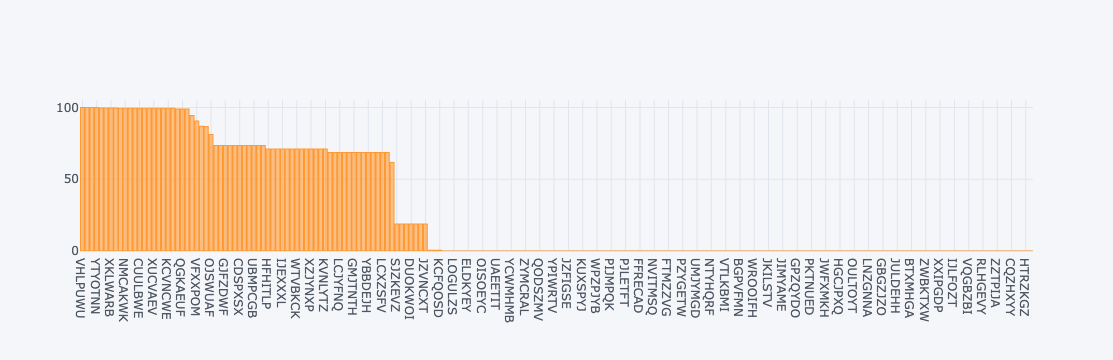

In [26]:
missing_percentage.sort_values(ascending=False).head(200).iplot(kind='bar')

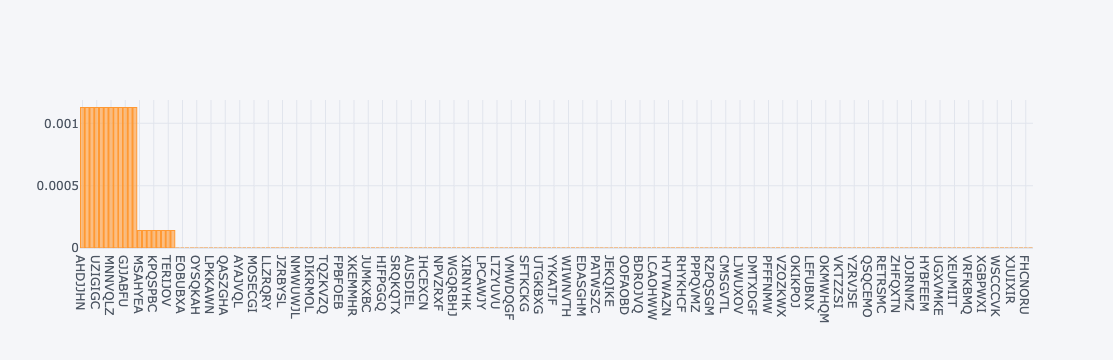

In [27]:
missing_percentage.sort_values(ascending=False).tail(200).iplot(kind='bar')

### Unique values

In [28]:
cols_unique_values = df.nunique()

In [29]:
univalued_cols = cols_unique_values[cols_unique_values == 1]
len(univalued_cols)

26

In [30]:
df = df.drop(columns=univalued_cols.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709518 entries, 0 to 726287
Columns: 720 entries, HKTLMYY to TLJYWBE
dtypes: float64(699), int64(21)
memory usage: 3.8 GB


### Correlations

In [31]:
sample_for_corr_calc = df.sample(frac=0.1, random_state=42)

In [32]:
valid_cols = missing_percentage[missing_percentage < 50].index
dtypes = df.dtypes
float_cols = [c for c in dtypes[dtypes == 'float64'].index.tolist() if c in valid_cols]
len(float_cols)

644

In [33]:
from dask.diagnostics import ProgressBar
import dask.dataframe as dd

ddf = dd.from_pandas(sample_for_corr_calc, npartitions=8)

with ProgressBar():
    correlation_matrix = ddf[float_cols].corr().compute()

[########################################] | 100% Completed |  2min 15.6s


In [34]:
melted_corr = correlation_matrix.stack().reset_index()
melted_corr.columns = ['col1', 'col2', 'correlation']
melted_corr.correlation = abs(melted_corr.correlation)
melted_corr = melted_corr[melted_corr['col1'] != melted_corr['col2']]

In [35]:
melted_corr = melted_corr.sort_values(by='correlation', ascending=False)
melted_corr.head(20)

,col1,col2,correlation
46364,LWFSOBB,HVHDNTE,1.0
43796,HVHDNTE,LWFSOBB,1.0
47007,WSTYRNH,HVHDNTE,1.0
43797,HVHDNTE,WSTYRNH,1.0
45721,PKCUSYS,HVHDNTE,1.0
43795,HVHDNTE,PKCUSYS,1.0
45077,UZXVNSW,ILHBFRB,1.0
43151,ILHBFRB,UZXVNSW,1.0
47011,WSTYRNH,LWFSOBB,1.0
46369,LWFSOBB,WSTYRNH,1.0


### Identifying highly correlated columns

In [36]:
highly_correlated = melted_corr[melted_corr.correlation > 0.8]
highly_correlated.shape

(6442, 3)

In [37]:
candidates_to_drop = set(highly_correlated.col1.values).union(set(highly_correlated.col2.values))
len(candidates_to_drop)

442

In [38]:
cols_duplicates = []
for cand_col in candidates_to_drop:
    subset = highly_correlated[highly_correlated.col1 == cand_col]
    n_duplicates, duplicates = len(subset), subset.col2.values.tolist()
    cols_duplicates.append((cand_col, n_duplicates, duplicates))    

In [39]:
sorted_cols_duplicates = sorted(cols_duplicates, key=lambda x: -x[1])

In [40]:
sorted_cols_duplicates[-5:]

[('OYSQKAH', 1, ['OMIIMXP']),
 ('QALPUXN', 1, ['MPCDRWL']),
 ('JYSKSPX', 1, ['BTKTNSN']),
 ('ZHFQXTN', 1, ['ZYMFJDH']),
 ('JMFGDPB', 1, ['AWMGPPL'])]

In [41]:
removed = set()
tmp = highly_correlated.copy()
for col, _, duplicates in sorted_cols_duplicates:
    if not col in tmp.col1.values:
        continue
    tmp = tmp[~tmp.col1.isin(duplicates)]
    removed.update(duplicates)
    print(f'Size dataframe: {len(tmp)} (Started at {len(highly_correlated)}. Unique columns remained: {tmp.col1.nunique()},  unique columns remodevd: {len(removed)}')

Size dataframe: 3176 (Started at 6442. Unique columns remained: 378,  unique columns remodevd: 64
Size dataframe: 2270 (Started at 6442. Unique columns remained: 346,  unique columns remodevd: 96
Size dataframe: 1697 (Started at 6442. Unique columns remained: 319,  unique columns remodevd: 123
Size dataframe: 1680 (Started at 6442. Unique columns remained: 318,  unique columns remodevd: 124
Size dataframe: 1646 (Started at 6442. Unique columns remained: 316,  unique columns remodevd: 126
Size dataframe: 1612 (Started at 6442. Unique columns remained: 314,  unique columns remodevd: 128
Size dataframe: 1566 (Started at 6442. Unique columns remained: 311,  unique columns remodevd: 131
Size dataframe: 1535 (Started at 6442. Unique columns remained: 309,  unique columns remodevd: 133
Size dataframe: 1450 (Started at 6442. Unique columns remained: 301,  unique columns remodevd: 141
Size dataframe: 1281 (Started at 6442. Unique columns remained: 288,  unique columns remodevd: 154
Size datafra

In [42]:
highly_correlated.col1.nunique()

442

In [43]:
tmp.col1.nunique() + len(set(removed))

442

## Removing highly correlated columns:

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709518 entries, 0 to 726287
Columns: 720 entries, HKTLMYY to TLJYWBE
dtypes: float64(699), int64(21)
memory usage: 3.8 GB


In [45]:
updated_df = df.drop(columns=removed)
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709518 entries, 0 to 726287
Columns: 368 entries, HKTLMYY to TLJYWBE
dtypes: float64(347), int64(21)
memory usage: 2.0 GB


## Saving

In [47]:
updated_df.reset_index(drop=True).to_feather('dataset_no_duplicates_no_univalue_no_correlated_columns.feather')